## Visualize weight maps

& in general nPRF parameter

In [4]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
base = 'encoding_model.denoise'
source_dir = op.join(bids_folder,'derivatives',base)
space = 'fsaverage5'
# plotting
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
from  nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage(space) # default 5

Text(0.5, 0.98, 'sub-05')

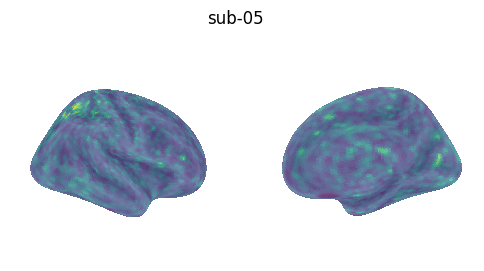

In [17]:
sub = '05' # good: 62 , bad:1,4,....
par = 'r2' # only looks sensibel for subs with large decodability! (check in decodingNPRFs....ipynb)

nPRF_dir = op.join(source_dir,f'sub-{sub}', 'ses-1','func' )
nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')
nprf_r2_L = nib.load(nPRF_fn).agg_data()
nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')
nprf_r2_R = nib.load(nPRF_fn).agg_data()
nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))

map = np.split(nprf_r2,2)[1].astype(float) # for i, hemi in enumerate(['L', 'R']): --> left first

figure, axes = plt.subplots(nrows=1, ncols=2,figsize = (6,3), subplot_kw=dict(projection='3d'))
for i, view in enumerate(['medial','lateral']):
    nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= map, # infl_right # pial_right
                view=view, colorbar=False, axes=axes[i],
                bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) # # ,cmap=cmap_two,

figure.suptitle(f'sub-{sub}')

encoding_model.2d.mixture.same_rfs.smoothed/sub-01/func/sub-01_task-magjudge_desc-gd.weight_space-T1w_pars.nii.gz

`cvr2`:  

`r2`: looks random/weird so far, though these files are the ones that give the average that makes sense... 
see `encoding_averageR2.ipynb`

next:
* maybe find 'good' subjects (decodability) (stim1)
* looks at weight maps from encoding_model.2d.mixture.same_rfs.smoothed (stim2)

In [3]:
# transform single .nii s

subject_id = 64

from numrisk.utils.data import Subject
from nilearn.maskers import NiftiMasker
from nipype.interfaces.freesurfer import SurfaceTransform
from nilearn import surface
from numrisk.fmri_analysis.surface.nPRFparams_to_surf import transform_fsaverage

sub = Subject(subject_id, bids_folder=bids_folder)
subject = f'{subject_id:02d}'
session=1
surfinfo = sub.get_surf_info_fs()
par_key = 'cvr2'
base = base = 'encoding_model.cv.denoise'

target_dir = op.join(bids_folder, 'derivatives', base, f'sub-{subject}', f'ses-1', 'func',)
fn = op.join(target_dir,f'sub-{subject}_ses-1_desc-{par_key}.optim_space-T1w_pars.nii.gz')            
#prf_pars_volume = sub.get_prf_parameters_volume(session=1, smoothed=False, denoise=True, keys=par_keys, return_image=True, cross_validated=True) 
prf_pars_volume = nib.load(fn)#.get_fdata()
print(np.shape(prf_pars_volume))

for hemi in ['L', 'R']:
    samples = surface.vol_to_surf(prf_pars_volume, surfinfo[hemi]['outer'], inner_mesh=surfinfo[hemi]['inner'])
    fs_hemi = 'lh' if hemi == 'L' else 'rh'
    im = nib.gifti.GiftiImage(darrays=[nib.gifti.GiftiDataArray(samples)]) # [:, ix]
    target_fn =  op.join(target_dir, f'sub-{subject}_ses-{session}_desc-{par_key}.optim.nilearn_space-fsnative_hemi-{hemi}.func.gii')
    #nib.save(im, target_fn)
    transform_fsaverage(target_fn, fs_hemi, f'sub-{subject}', bids_folder,target_space='fsaverage')
    transform_fsaverage(target_fn, fs_hemi, f'sub-{subject}', bids_folder,target_space='fsaverage5')


(56, 70, 52)


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


TraitError: The 'source_file' trait of a SurfaceTransformInputSpec instance must be a pathlike object or string representing an existing file, but a value of '/mnt_03/ds-dnumrisk/derivatives/encoding_model.cv.denoise/sub-64/ses-1/func/sub-64_ses-1_desc-cvr2.optim.nilearn_space-fsnative_hemi-L.func.gii' <class 'str'> was specified.